## Financial Modeling Group Project - ARCH Model for Volatility
**Authors: Aidan, Arzaan, and Leo**

**Date:** April 2025  


**Description:**  
Options pricing is one of the hardest problems in Finance. Not only because it is a zero-sum game but also it requires a lot more inputs than just current stock price and time. Volatility is a key input in options pricing and the common nomenclature and assumption of  constant volatility is not only incorrect but also extremely harmful in understanding options pricing.

Therefore, we wanted to explore the heteroskedasticity of volatility, explore a method to model it, and use it to predict options pricing. We decided to use the ARCH -- Autoregressive conditional heteroskedasticity -- model to understand and predict variability. It is the simplest and most fundamental model in modelling volatility and a great first step. We will be using a mathematical (manually building an arch model), financial (using arch to model volatility to predict options pricing), and data science (documentation, testing, and analysis of data) perspectives to enhance our understandings in this project.


**End‑to‑end pipeline:**
1. Data Extraction, Transformation, and Loading  
2. Exploratory Data analysis (EDA)  
3. ARCH(1) and ARCH(m) Model Estimation  
4. Volatility Forecasting  
5. Black–Scholes option pricing  

**Sources:**
1. yfinance API
2. https://www.youtube.com/watch?v=anCMsvUbKlM
3. https://stats.stackexchange.com/questions/173022/is-a-garch-model-a-regression-model
4. https://online.stat.psu.edu/stat510/lesson/11/11.1




## Imports and Installation
Let's start by installing all the neccessary packages and imports. Google colab already includes many imports (such as numpy, pandas, scipy, etc.); however, we have to manually install arch and yfinance to the notebook.

In [1]:
!pip install arch yfinance --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 9.6 MB/s eta 0:00:00


In [45]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
from arch import arch_model
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.layouts import column
from datetime import date, timedelta, datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

print('Imports Done :)')

Imports Done :)


## 1. Data Extraction, Transformation, and Loading


Now that we have our inputs, let's download our base data to understand the need for `ARCH` and model volatility.

We will be using the Yahoo Finance API to fetch market data. So, let's start with establishing the basics we will be using, including ticker, start and end date (because we are using this for options).

In [6]:
# Parameters
ticker = "SPY"                # underlying asset
start_date  = "1999-12-31"
end_date    = date.today()

# Download Adjusted Close to account for dividends, stock splits, etc.
spy_data = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    auto_adjust=True,
    threads=False,
    progress=False
  )

# The data comes with an extra level signfying the ticker 'SPY', so let's drop that since it is redudant
spy_data.columns = spy_data.columns.droplevel(level=1)
prices = spy_data['Close'] # Our effective pandas dataframe
spy_data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
1999-12-31,93.328369,93.725511,92.931227,93.308512,3172700
2000-01-03,92.414955,94.202094,91.422100,94.202094,8164300
2000-01-04,88.800957,91.541237,88.731457,91.203666,8089800
2000-01-05,88.959778,89.932775,87.212354,88.920064,12177900
2000-01-06,87.530098,89.912950,87.530098,88.721524,6227200


## 2. Exploratory Data Analysis
Luckily our dataset is limited to only SPY prices, so we can move on top doing preliminary/exploratory data analysis. This inlcudes, plotting SPY returns (cumulative and daily) to understand trends, calculating summary statistics to infer distributions, and analyzing ACF and PACF for returns to solidify the need for the ARCH model.

### Plotting Returns
First, let's plot the cumulative returns (prices) to see what we are working with along with daily returns. For the cumulative plot we will use our prices dataframe and for the daily returns we will calculate it using log returns as a percentage to make it more interpretable.


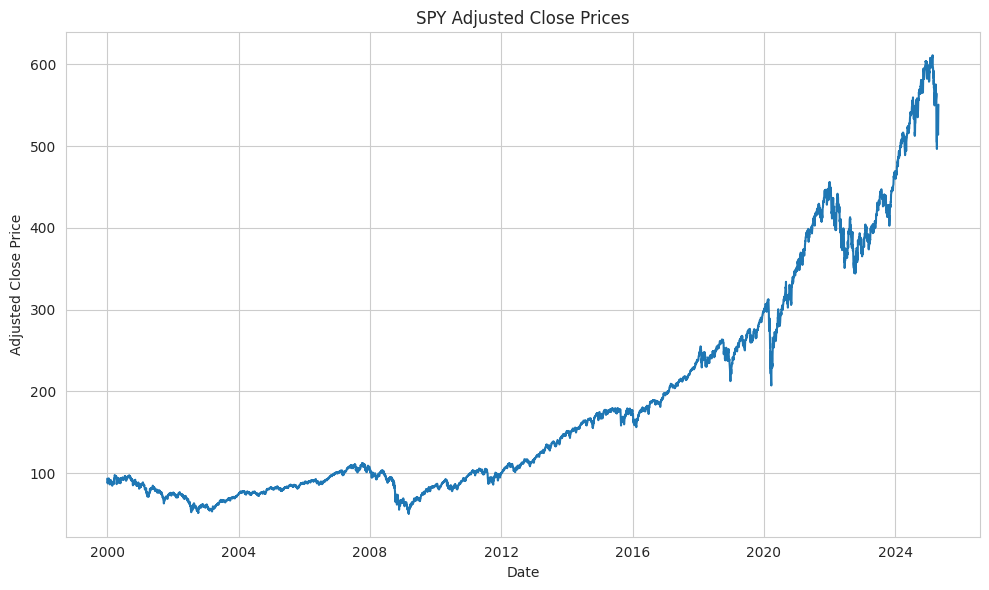

In [7]:
# Using Seaborn and Matplotlib to plot SPY Adjusted Close Prices
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(data=spy_data, x='Date', y='Close')
plt.title(f"{ticker} Adjusted Close Prices")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.tight_layout()
plt.show()

In [10]:
# Using Bokeh to plot daily returns
# We wanted to use multiple set of visualization libraries to work on our breath of skill
# It is also interactive and helps us zoom in and out of the plot
# Enable Bokeh in the notebook
output_notebook()

# Compute daily percent log‑returns as a percentage
returns = 100 * np.log(prices / prices.shift(1))
returns = returns.dropna().rename("returns")

# Prepare a ColumnDataSource for Bokeh ---
source = ColumnDataSource(data={'date': returns.index, 'returns': returns.values})

# Create the figure
p = figure(
    title=f"{ticker} Daily Log Returns (%)",
    x_axis_type="datetime",
    width=1000,
    height=600,
    tools="pan,wheel_zoom,box_zoom,reset"
)

# Draw the line
line = p.line('date', 'returns', source=source, line_width=2, legend_label="Log Return")

# Draw circles at each point (invisible until hover)
circles = p.circle('date', 'returns', source=source, size=6,
                   alpha=0, hover_alpha=0.8, hover_fill_color='orange',
                   legend_label="Data Point")

# Add a HoverTool ---
hover = HoverTool(
    renderers=[circles],
    tooltips=[("Date", "@date{%F}"), ("Return", "@returns{0.2f}%")],
    formatters={'@date': 'datetime', },
    mode='mouse')
p.add_tools(hover)

# Axis labels
p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Return (%)"

# Show the plot
show(p)

### Summary Statistics of Returns

Now, let's compute the mean, standard deviation, skewness, and kurtosis of our daily log‐returns.
- **Mean**: shows any drift in returns (often near zero for large indices).  
- **Std. Dev.**: our daily volatility estimate.  
- **Skewness**: measures asymmetry—negative skew suggests downside risk is larger.  
- **Kurtosis**: “fat tails” beyond the Normal (kurtosis >3) indicate extreme moves happen more often than Gaussian.  

These moments help us understand the distribution of returns before modeling volatility.  

In [11]:
# Compute summary statistics as a Series
stats = returns.describe()

# Add skewness and kurtosis
stats['skewness'] = returns.skew()
stats['kurtosis'] = returns.kurtosis()

# Display
display(stats)

,returns
count,6367.000000
mean,0.027877
std,1.232577
min,-11.588664
25%,-0.471585
50%,0.067687
75%,0.599300
max,13.557726
skewness,-0.204406
kurtosis,11.403680


#### Interpreting the SPY Daily Log‑Returns Summary


| Statistic   | Value       | Interpretation                                                                                         |
|-------------|-------------|--------------------------------------------------------------------------------------------------------|
| **Count**   | 6,362       | Number of trading days in our sample (2015–2025).                                                       |
| **Mean**    | 0.027%      | On average SPY returned +0.027% per day—very close to zero, indicating no persistent drift on daily scale. |
| **Std. Dev.** | 1.232%    | Typical daily volatility is about ±1.23%; this is our baseline risk measure.                           |
| **Min**     | -11.59%     | The worst one‑day drop in this period was –11.59%.                                                     |
| **25th %ile** | -0.472%   | 25% of returns were below –0.472%.                                                                     |
| **Median**  | 0.067%      | Half of all days had returns below +0.067%; the distribution is roughly centered around zero.         |
| **75th %ile** | +0.598%   | 25% of returns exceeded +0.598%.                                                                        |
| **Max**     | +13.56%     | The best one‑day gain was +13.56%.                                                                     |
| **Skewness**| –0.204      | Slight negative skew: extreme negative moves are a bit larger or more frequent than extreme positives. |
| **Kurtosis**| 11.443      | Far above 3: “fat tails” indicate large shocks occur much more often than under a Normal distribution.|

**Implications:**  
- The **positive near‑zero mean** confirms SPY has a very slight positive drift for the SPY; however, it also confirms that a lot of the daily return can be attributed to volatility/error/random-walk.  
- The **high kurtosis** warns us that extreme events (crashes or spikes) are far more common than the Gaussian model would imply, justifying the use of an ARCH/GARCH model that can capture volatility clustering and heavy tails.  
- The **negative skew** gives us a glimpse that downside risk is slightly more pronounced, so risk management should account for left‑tail events.  

**Note:** the markdown table was last updated April 26th 2025, the actual output may be different depending on new data when the notebook is run again and automatically updates to the latest day. This is true and a disclaimer for most of the notebook and analysis.

### ACF & PACF Diagnostics for Returns and Squared Returns

A common analysis for daily returns (which as we observed above is largely a function of daily volatility) and their correlation is using Autocorrelation and Partial Autocorrelation functions

**Therefore we will**
1. Plot the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** of the raw returns (`returns`).  
2. Plot the ACF and PACF of the **squared returns** (`returns**2`).

**Why:**  
- **ACF (lag k):** correlation between today’s value and the value k days ago.  
- **PACF (lag k):** correlation between today’s value and the value k days ago **after** removing the influence of all shorter lags.

In an *efficient market* you expect no serial correlation in raw returns (ACF ≈ 0).

However, **volatility clustering** (the ARCH effect) manifests as significant autocorrelation in **squared** returns—large shocks tend to follow large shocks.  

Seeing spikes in the ACF/PACF of squared returns justifies fitting an ARCH/GARCH model.  

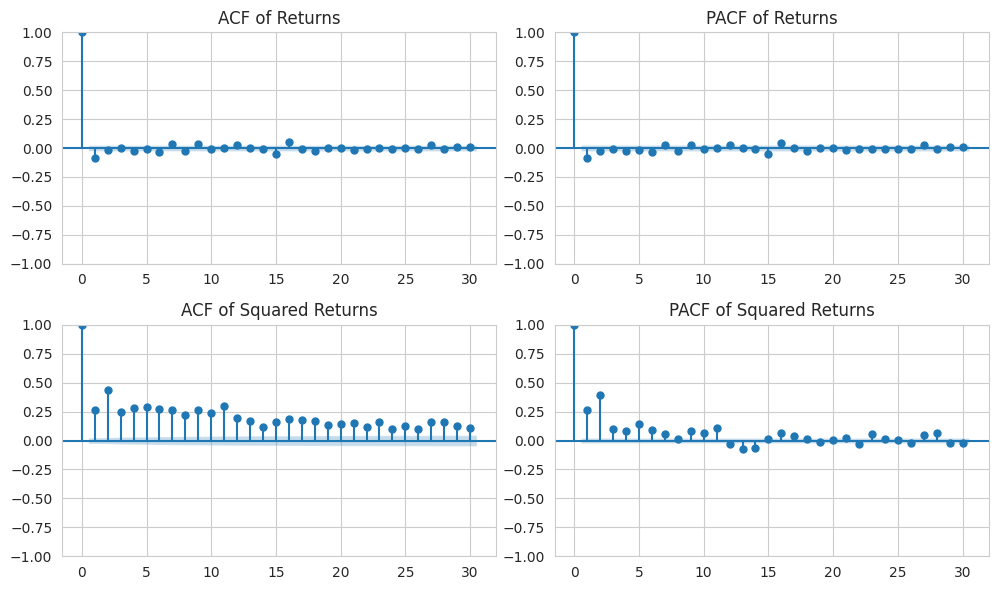

In [13]:
# Create 2×2 grid for plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Row 1: raw returns
plot_acf(returns,    lags=30, ax=axes[0, 0], title="ACF of Returns")
plot_pacf(returns,   lags=30, ax=axes[0, 1], title="PACF of Returns")

# Row 2: squared returns
plot_acf(returns**2, lags=30, ax=axes[1, 0], title="ACF of Squared Returns")
plot_pacf(returns**2, lags=30, ax=axes[1, 1], title="PACF of Squared Returns")

plt.tight_layout()
plt.show()

#### Interpreting the ACF & PACF Plots

1. **ACF of Returns**  
   - Almost all bars lie within the significance bounds (dashed lines), so there is **no meaningful serial correlation** in the raw returns.  
   - **Implication:** Returns behave like a white‐noise process—no predictable pattern in the mean.  

2. **PACF of Returns**  
   - Same story: no significant partial correlations at any lag.  
   - **Implication:** We do not need an AR or MA term in the mean equation; a simple zero‑mean model is fine.  

3. **ACF of Squared Returns**  
   - Strong, slowly decaying positive autocorrelations at lags 1 through ~10.  
   - **Implication:** **Volatility clustering**—large (or small) shocks tend to be followed by similarly large (or small) shocks. This is the hallmark of ARCH/GARCH effects.  

4. **PACF of Squared Returns**  
   - A large spike at lag 1 (and smaller but still significant at lag 2), then the partial correlations drop off.  
   - **Implication:** An **ARCH(1)** (or possibly ARCH(2)) specification should capture most of the conditional heteroskedasticity.  

---

**Conclusion:**  
- Since raw returns show no serial dependence, we model the **mean** as constant (or zero).  
- The pronounced autocorrelation in **squared** returns justifies fitting an ARCH‑type model—starting with ARCH(1) based on the PACF cutoff.  

## 3. ARCH Model Building & Specification

We will create an ARCH model from scratch, starting with ARCH(1) and then generalizaing it to ARCH(m). This is the meat of the project and requires the most amount of technical and mathematics knowledge.

### ARCH(1) Model
Let's start by manually defining a ARCH(1) model to learn how to generalize it. Luckily, for the ARCH(1) we can work directly with returns because of its simplicity (it is essentially a time-series simple linear regression model).

In previous cells we demeaned/assumed that our returns $r_t$ satisfy
$$
r_t = \epsilon_t,\quad
\epsilon_t = \sigma_tz_t,\quad
z_t \sim N(0,1),
$$
with conditional variance
$$
\sigma_t^2 = \omega + \alpha,\epsilon_{t-1}^2,
$$
where $\omega > 0$ and $0 \le \alpha < 1$.

To estimate $\omega$ and $\alpha$, we maximize the Gaussian log‑likelihood
$$
\ell(\omega,\alpha)
= -\tfrac12 \sum_{t=1}^T \Bigl[\ln(2\pi)
	\ln(\sigma_t^2)
	\tfrac{r_t^2}{\sigma_t^2}\Bigr].
$$
Equivalently, we minimize the negative log‑likelihood
$-\ell(\omega,\alpha)$ with respect to $\omega$ and $\alpha$.

The code below implements this log likelihood function to solve for our parameters.

In [14]:
def arch1_nll(params, data):
    """
    Negative log‑likelihood for ARCH(1):
      params = [omega, alpha]
      data   = pd.Series of returns
    """
    w, a = params
    # impose ω>0, 0≤α<1
    if w <= 0 or a < 0 or a >= 1:
        return 1e8
    eps = data.values
    T   = len(eps)
    # initialize variance series
    sigma2 = np.empty(T)
    sigma2[0] = np.var(eps)

    for t in range(1, T):
        sigma2[t] = w + a * eps[t-1]**2

    # compute log‑likelihood contributions
    ll = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + (eps**2)/sigma2)
    # return negative total for minimizer
    return -ll.sum()

# Sanity check at an initial guess
init_guess = [0.1 * returns.var(), 0.1]
print("NLL at init guess:", arch1_nll(init_guess, returns))

NLL at init guess: 18952.57637826287


### Defining a Generic ARCH(m) Negative Log‑Likelihood

We can now generalize our ARCH(1) negative log‑likelihood to an ARCH(m) model:

$$
\sigma_t^2 = \omega + \sum_{i=1}^m \alpha_i,\epsilon_{t-i}^2,
$$

with parameters ${\omega, \alpha_1, \dots, \alpha_m}$.

Below is a function that computes the negative log‑likelihood for any order $m$. And since we are working with a multiple linear regression parameter estimation, it is easier to now work simply with volatility and previous volatility, which is defined as the errors of the daily returns.

In [15]:
def arch_m_nll(params, data, m):
    """
    Negative log‑likelihood for an ARCH(m) model.

    params : array‑like, length = m+1
        [omega, alpha_1, alpha_2, ..., alpha_m]
    data : pd.Series
        The return series (assumed zero mean).
    m : int
        The ARCH order.
    """
    # Unpack
    omega = params[0]
    alphas = np.asarray(params[1:])

    # Enforce positivity and stationarity
    if omega <= 0 or np.any(alphas < 0) or alphas.sum() >= 1:
        return 1e8  # large penalty

    eps = data.values
    T = len(eps)

    # Prepare array for conditional variances
    sigma2 = np.empty(T)
    # Initialize first m values at sample variance
    init_var = np.var(eps)
    sigma2[:m] = init_var

    # Recursively compute sigma2[t]
    for t in range(m, T):
        past_sq = eps[t-m:t]**2  # last m squared residuals
        sigma2[t] = omega + np.dot(alphas, past_sq[::-1])

    # Log‑likelihood for Gaussian innovations
    ll = -0.5 * (np.log(2*np.pi) + np.log(sigma2) + (eps**2) / sigma2)

    # Return negative total
    return -ll.sum()

# Quick test for m=3
test_params = [0.1*returns.var()] + [0.1]*3
print("ARCH(3) NLL at test params:", arch_m_nll(test_params, returns, m=3))

ARCH(3) NLL at test params: 11353.713266696388


### Fitting ARCH(m) Models & Model Selection

Now that we have our generalized ARCH(m) model, let's find the best m, i.e., the best lag for our data. To do this, we will use Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC). Which are model selection criteria that help us choose the best model from a set of candidate models. They both consider the model's goodness-of-fit (how well it explains the data) and complexity (number of parameters) to avoid overfitting. Thus,

1. **Loop** over candidate orders $m\in\{1,2,3\}$.  

2. **Estimate** each ARCH(m) by minimizing our `arch_m_nll` function:
   - Initial guess:  
     - $\omega^{(0)} = 0.1\times\mathrm{Var}(\text{returns})$  
     - $\alpha_i^{(0)} = 0.1$ for $i=1,\dots,m$  
   - Bounds:  
     - $\omega > 0$  
     - $0 \le \alpha_i < 1$ and $\sum \alpha_i < 1$ (via bound on each $\alpha_i$).  

3. **Compute** for each fitted model:
   - **NLL**: negative log‑likelihood at the optimum.  
   - **AIC** = $2k + 2\,\mathrm{NLL}$, with $k = m+1$ parameters.  
   - **BIC** = $\ln(T)\,k + 2\,\mathrm{NLL}$.  
   
4. **Compare** AIC & BIC across $m$ and pick the order $m^*$ with the lowest criterion (trade‑off fit vs complexity).

This systematic approach ensures we don’t over‑ or under‑parameterize our volatility model.

In [16]:
# Candidate ARCH orders
orders = range(1, 16)
results = []

for m in orders:
    # 1) Initial guesses: omega = 0.1*var, alphas = 0.1 each
    init = [0.1 * returns.var()] + [0.1] * m

    # 2) Bounds: omega > 0; each alpha in [0, 1)
    bounds = [(1e-8, None)] + [(0, 1 - 1e-8)] * m

    # 3) Minimize negative log-likelihood
    res_m = minimize(
        fun=arch_m_nll,
        x0=init,
        args=(returns, m),
        bounds=bounds,
        method="L-BFGS-B"
    )

    # 4) Gather fit metrics
    k = m + 1                          # number of parameters
    nll = res_m.fun                    # minimized NLL
    aic = 2 * k + 2 * nll              # AIC formula
    bic = np.log(len(returns)) * k + 2 * nll  # BIC formula

    results.append({
        'm': m,
        'omega': res_m.x[0],
        'alphas': [round(a, 4) for a in res_m.x[1:]],
        'NLL': round(nll, 2),
        'AIC': round(aic, 2),
        'BIC': round(bic, 2),
        'converged': res_m.success
    })

# 5) Present results as a DataFrame
df_results = pd.DataFrame(results).set_index('m')
df_results

,omega,alphas,NLL,AIC,BIC,converged
m,,,,,,
1,0.902829,[0.4583],9.821110e+03,1.964621e+04,1.965973e+04,True
2,0.587506,"[0.2795, 0.3624]",9.383450e+03,1.877290e+04,1.879318e+04,True
3,0.431472,"[0.1738, 0.3296, 0.2458]",9.159040e+03,1.832608e+04,1.835311e+04,True
4,0.343295,"[0.1247, 0.2364, 0.2126, 0.2238]",9.007070e+03,1.802414e+04,1.805794e+04,True
5,0.298518,"[0.1065, 0.204, 0.168, 0.2042, 0.1378]",8.946710e+03,1.790543e+04,1.794598e+04,True
6,0.282189,"[0.0904, 0.1825, 0.1505, 0.1659, 0.1246, 0.101]",8.908300e+03,1.783060e+04,1.787791e+04,True
7,0.263672,"[0.0863, 0.1713, 0.1365, 0.156, 0.1101, 0.0929...",8.887780e+03,1.779157e+04,1.784564e+04,True
8,0.237950,"[0.0917, 0.1577, 0.1252, 0.1465, 0.0883, 0.069...",8.853390e+03,1.772479e+04,1.778562e+04,True
9,0.222888,"[0.0875, 0.1555, 0.1197, 0.1398, 0.085, 0.0606...",8.842690e+03,1.770537e+04,1.777296e+04,True


#### Selecting the Optimal ARCH(m) Order

From the table of fit statistics we can see that

- **Minimum AIC** occurs at **m = 9** (AIC = 17,705).  
- **Minimum BIC** also occurs at **m = 9** (BIC = 17,773).  

Therfore, we proceed with **ARCH(9)** as it gives the best trade‑off between model fit and complexity according to both AIC and BIC. The code itself doesn't hardcode this and just automatically takes the best **m** for the ARCH(m) model.

## 4. Volatility Forecasting

In this section, we will use our model to plot volatility, validate it, backtest it, and then finally forecast it on a rolling basis

### Computing & Plotting the ARCH Model’s Past Conditional Volatility

Now that we’ve automatically selected ARCH(m^*) with

$
m^* = \underset{m}{\arg\min}\,\mathrm{AIC},
$

we reconstruct the conditional variance series:

$
\widehat\sigma_t^2 \;=\; \omega_{\mathrm{best}}
\;+\;\sum_{i=1}^{m^*} \alpha_i^{\mathrm{best}}\;r_{t-i}^2,
$

where $r_t$ are our demeaned returns and $\widehat\sigma_1^2 = \mathrm{Var}(r)$.  

We can plot the last 200 days of $\widehat\sigma_t$ to visualize how the model captures volatility clustering.

In [17]:
# 1) Automatically find the order m that minimizes AIC
best_m = df_results['BIC'].idxmin()   # change to ['BIC'] if you prefer BIC

# 2) Extract the estimated parameters for that order
omega_best   = df_results.loc[best_m, 'omega']
alphas_best  = df_results.loc[best_m, 'alphas']

print(f"Selected ARCH({best_m}) as optimal by AIC")
print(f"omega_best  = {omega_best:.6f}")
print(f"alphas_best = {alphas_best}")

Selected ARCH(9) as optimal by AIC
omega_best  = 0.222888
alphas_best = [np.float64(0.0875), np.float64(0.1555), np.float64(0.1197), np.float64(0.1398), np.float64(0.085), np.float64(0.0606), np.float64(0.0552), np.float64(0.1004), np.float64(0.0547)]


An interesting note before we continue is that there are no negative weightings for any of the days. Now this could be for a lot of mathematical reasons, but intuitively it aligns with our previous analysis that in a short enough lag, current volatility is positively correlated with recent past volatility.

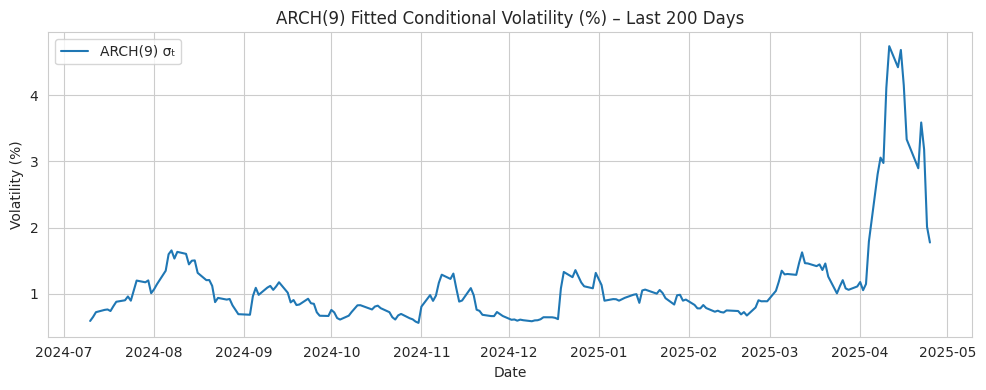

In [19]:
# Use best_m, omega_best, alphas_best from previous cell
m = best_m
omega = omega_best
alphas = alphas_best  # list of length m

# Compute conditional variances
T = len(returns)
sigma2_best = np.empty(T)
sigma2_best[:m] = returns.var()  # initialize first m values

for t in range(m, T):
    past_sq = returns.values[t-m:t]**2
    sigma2_best[t] = omega + np.dot(alphas, past_sq[::-1])

# 3) Plot the last 200 days of conditional volatility (%)
plt.figure(figsize=(10, 4))
plt.plot(returns.index[-200:], np.sqrt(sigma2_best[-200:]), label=f'ARCH({m}) σₜ')
plt.title(f'ARCH({m}) Fitted Conditional Volatility (%) – Last 200 Days')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

### Verifying Manual ARCH($m^*$) with the `arch` Library

To ensure our manual ARCH estimates are correct, we should:

1. **Fit** an ARCH($m^*$) model using the `arch` library’s `arch_model`.  
2. **Compare** the library’s estimated parameters $\omega$ and $\alpha_i$ to our manual values.  
3. **Plot** the library’s fitted conditional volatility against our manual $\widehat\sigma_t$ to confirm they coincide.

This cross‑check gives confidence that our implementation of the likelihood and recursion is sound.

In [24]:
# Ensure p is a native Python int
p = int(best_m)

# Fit ARCH(p) using the library
am = arch_model(returns, vol='ARCH', p=p, mean='Zero', dist='normal')
res_lib = am.fit(disp='off')
print(res_lib.summary())

# Extract library parameters
params_lib = res_lib.params
omega_lib = params_lib['omega']
alphas_lib = [params_lib[f'alpha[{i+1}]'] for i in range(p)]
print(f"\nLibrary estimates:\n ω = {omega_lib:.6f}\n α = {[round(a,6) for a in alphas_lib]}")

# Compare to manual
print(f"\nManual estimates:\n ω = {omega_best:.6f}\n α = {alphas_best}")

# Plot fitted volatilities
vol_lib = res_lib.conditional_volatility
vol_manual = np.sqrt(sigma2_best)

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -8836.79
Distribution:                  Normal   AIC:                           17693.6
Method:            Maximum Likelihood   BIC:                           17761.2
                                        No. Observations:                 6367
Date:                Sun, Apr 27 2025   Df Residuals:                     6367
Time:                        05:07:52   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.2223  2.282e-02      9.745  1.941e-22    

Our model works! The library and our manual estimates give roughly the same answer and that is reassuring. While the library does give us more specific statistical information, our model workl. And we can see this by plotting the estimates one on top of each other.

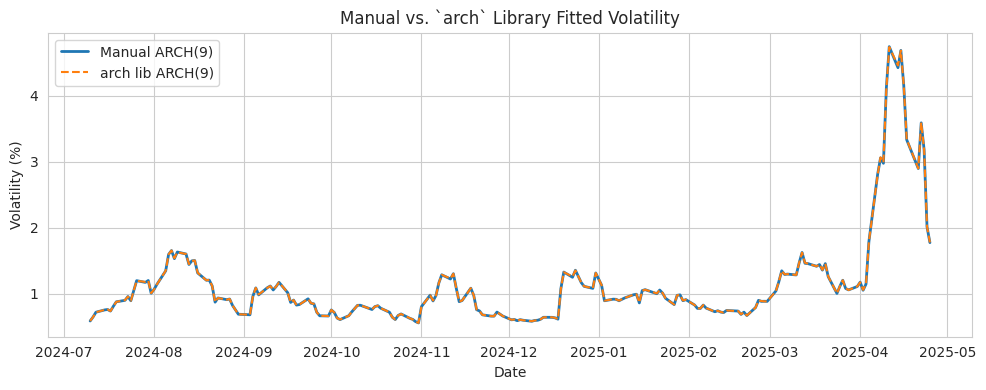

In [25]:
# Plotting both models
plt.figure(figsize=(10,4))
plt.plot(returns.index[-200:], vol_manual[-200:], label=f'Manual ARCH({p})', lw=2)
plt.plot(returns.index[-200:], vol_lib[-200:],     label=f'arch lib ARCH({p})', linestyle='--')
plt.title('Manual vs. `arch` Library Fitted Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.legend()
plt.tight_layout()
plt.show()

If the glove don't fit you must acquit. The glove most definitely fit and the plot is proof of that. Now with our new found confidence let us apply our model to forecast future volatility.

### Forecasting Future Volatility

We now use our selected ARCH($m^*$) parameters $\omega_{\mathrm{best}}$ and $\{\alpha_i^{\mathrm{best}}\}$ to forecast the next $H$ trading‐day variances.

**Method:**  
1. Let $m = m^*$.  
2. Collect the last $m$ squared returns:  
   $\{\epsilon_{T-m+1}^2,\dots,\epsilon_T^2\}$.  
3. Recursively compute  
   $
     \widehat\sigma_{T+h}^2
     = \omega_{\mathrm{best}}
     + \sum_{i=1}^m \alpha_i^{\mathrm{best}}\;x_{h,i},
   $    
   
   where  
   $x_{h,i} =$\begin{cases}
                \epsilon_{T+h-i}^2, & \text{if } h-i \le 0,\\
                \widehat\sigma_{T+(h-i)}^2, & \text{if } h-i > 0.
                \end{cases}
   
4. Convert to annualized volatility:  
   $\widehat\sigma_{T+h,\mathrm{ann}} = \sqrt{\widehat\sigma_{T+h}^2 \times 252}$.

We do this initially for the first 30 days.

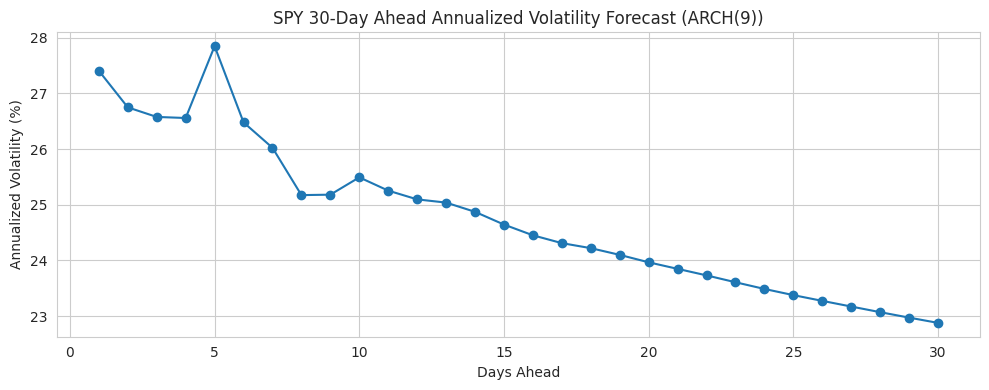

In [26]:
# Forecast settings
H = 30               # days ahead
m = best_m           # selected ARCH order
omega = omega_best
alphas = alphas_best # list of length m

# Initialize buffer with last m realized squared returns
past_sq = list((returns.values[-m:])**2)

# Recursive forecast of daily variances
var_forecast = []
for h in range(H):
    # compute forecasted variance using the last m values in past_sq
    forecast_var = omega + sum(alphas[i] * past_sq[-(i+1)] for i in range(m))
    var_forecast.append(forecast_var)
    past_sq.append(forecast_var)  # include for future iterations

# Annualize to get volatility (%)
vol_ann = np.sqrt(np.array(var_forecast) * 252)

# Plot
plt.figure(figsize=(10,4))
plt.plot(range(1, H+1), vol_ann, marker='o')
plt.title(f"{ticker} {H}-Day Ahead Annualized Volatility Forecast (ARCH({m}))")
plt.xlabel("Days Ahead")
plt.ylabel("Annualized Volatility (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

And that plot again looks very good. However, in our specific context it starts of high and falls slowly and rather predictably. So, what is happening here?

We plotted an ARCH(9) model for 30 days. This means that by the 10th day, the model is using only forecasted data to create new forecasted data. Because of the static parameters, eventually this leads the volatility to follow a straight line. Therefore, it means that for our forecasts we must limit it to only the number of days **m**, our lags.

### Monte Carlo Simulation of Future Volatility

Using that knowledge we can expand our idea and instead of a single deterministic forecast, we can generate a **distribution** of future volatility trajectories by introducing randomness at the volatility level:

1. **Model:**  
   $
     \epsilon_{T+h} = \sigma_{T+h}\,z_{T+h},\quad z_{T+h}\sim \mathcal{N}(0,1),
   $    
   $
     \sigma_{T+h}^2
     = \omega_{\mathrm{best}}
     + \sum_{i=1}^{m^*}\alpha_i^{\mathrm{best}}\;\epsilon_{T+h-i}^2.
   $
2. **Procedure:**  
   - Initialize each path with the last $m^*$ realized squared returns $\epsilon_{T-m^*+1}^2,\dots,\epsilon_T^2$.  
   - For each of \(N\) simulation runs and each day \(h=1,\dots,H\):  
     1. Draw $z_{T+h}\sim\mathcal{N}(0,1)$.  
     2. Compute $\epsilon_{T+h} = \sigma_{T+h}\,z_{T+h}$.  
     3. Update $\sigma_{T+h}^2 = \omega_{\mathrm{best}} + \sum_{i=1}^{m^*}\alpha_i^{\mathrm{best}}\;\epsilon_{T+h-i}^2.$
   - Record $\sigma_{T+h}$.  
3. **Outcome:**  
   - A cloud of $N$ possible volatility paths, reflecting both model structure and random shocks.  
   - We can summarize with percentiles (e.g., median, 5th/95th) or visualize the range.

This captures the uncertainty in volatility itself, rather than only a single forecast.

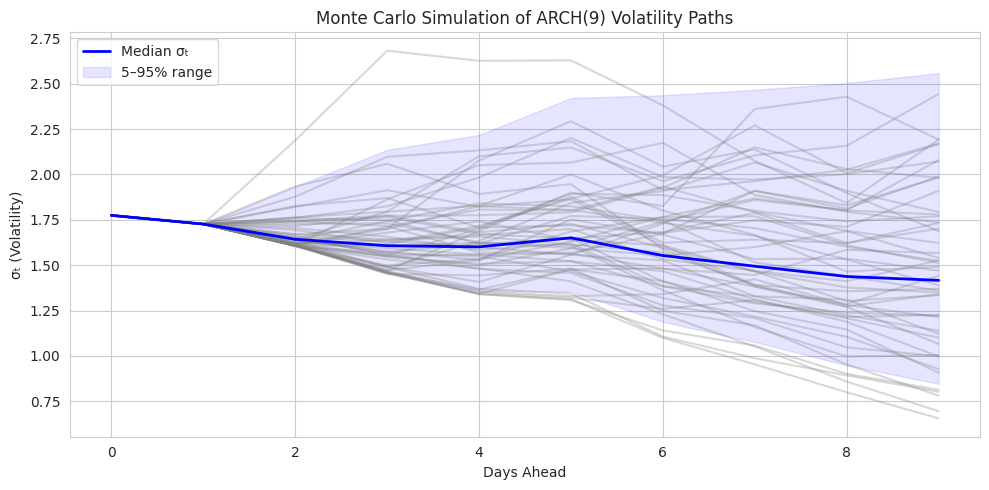

In [27]:
# Simulation settings
N = 500    # number of simulated volatility paths
H = best_m     # forecast horizon (days)
m = best_m # selected ARCH order
omega = omega_best
alphas = alphas_best  # list of length m

# Initialize container: shape (H+1, N)
sigma_paths = np.zeros((H+1, N))

# Starting sigmas: last observed conditional vol (sqrt of sigma2_best[-1])
sigma_paths[0, :] = np.sqrt(sigma2_best[-1])

# Prepare initial eps squared buffers for each path
init_eps_sq = returns.values[-m:]**2  # array length m

# Simulate
for j in range(N):
    eps_sq_buffer = list(init_eps_sq.copy())
    for h in range(1, H+1):
        # forecast variance at T+h
        var_h = omega + sum(alphas[i] * eps_sq_buffer[-(i+1)] for i in range(m))
        sigma_h = np.sqrt(var_h)

        # draw shock and compute epsilon
        z = np.random.randn()
        eps_h = sigma_h * z

        # store sigma
        sigma_paths[h, j] = sigma_h

        # update buffer
        eps_sq_buffer.append(eps_h**2)

# Plot a subset of volatility paths
plt.figure(figsize=(10,5))
for i in range(min(50, N)):
    plt.plot(range(H+1), sigma_paths[:, i], color='grey', alpha=0.3)

# Also plot the median and 5th/95th percentiles
pct5  = np.percentile(sigma_paths, 5, axis=1)
pct50 = np.percentile(sigma_paths, 50, axis=1)
pct95 = np.percentile(sigma_paths, 95, axis=1)
plt.plot(range(H+1), pct50, color='blue', label='Median σₜ', lw=2)
plt.fill_between(range(H+1), pct5, pct95, color='blue', alpha=0.1, label='5–95% range')

plt.title(f"Monte Carlo Simulation of ARCH({m}) Volatility Paths")
plt.xlabel("Days Ahead")
plt.ylabel("σₜ (Volatility)")
plt.legend()
plt.tight_layout()
plt.show()

Now, this plot seems far more likely in representing daily volatility. It has the outlier extreme volatility increases but also settles down on average with a more representative mean.

### Backtesting Volatility Forecasts

To validate our ARCH($m^*$) forecasts, we can also compare them against **realized volatility** over rolling windows. Now we learned that our forecasted days should not exceed the number of lags, so let us pick h days (h = 5) and build our backtest:

1. **Realized volatility** over next $h$ days (daily returns) is  
   $
     \sigma_{\text{realized},t+h}
     = \sqrt{\frac{252}{h}\sum_{i=1}^{h} r_{t+i}^2}.
   $
2. For each date $t$ in our sample (excluding the last $H$ days),  
   - Compute the $H$-day ahead forecast $\widehat\sigma_{t+h}$.  
   - Compute realized volatility over the same horizon.  
3. **Metrics:**  
   - **MAE** = $\frac1N\sum|\widehat\sigma - \sigma_{\text{realized}}|$  
   - **RMSE** = $\sqrt{\frac1N\sum(\widehat\sigma - \sigma_{\text{realized}})^2}$  
4. **Plot** forecast versus realized volatility to visualize forecast accuracy.

Backtest H=5 days ⇒ MAE = 5.822%, RMSE = 8.254%


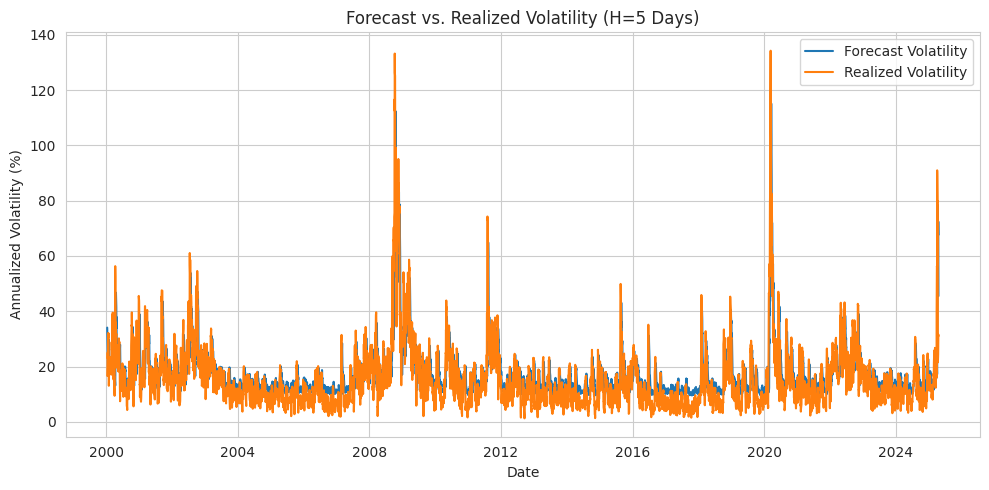

In [35]:
# Settings
H = round(best_m/2 + 0.5)  # forecast horizon
m = best_m
omega = omega_best
alphas = alphas_best

# Prepare storage
forecast_vol = []
realized_vol = []
dates_bt = returns.index[m:len(returns)-H]  # backtestable dates

for idx in range(m, len(returns)-H):
    # 1) Build buffer of last m squared returns
    eps = returns.values[:idx]  # up to t
    past_sq = list(eps[-m:]**2)

    # 2) Recursive forecast H steps ahead
    for _ in range(H):
        var_h = omega + sum(alphas[i] * past_sq[-(i+1)] for i in range(m))
        past_sq.append(var_h)
    # Annualize the H‑day ahead forecast
    forecast_vol.append(np.sqrt(past_sq[-1] * 252))

    # 3) Realized volatility over next H days
    fut = returns.values[idx:idx+H]  # next H returns
    realized_vol.append(np.sqrt((fut**2).sum() * 252 / H))

# Build DataFrame
df_backtest = pd.DataFrame({
    'forecast_vol': forecast_vol,
    'realized_vol': realized_vol
}, index=dates_bt)

# Metrics
mae  = (df_backtest.forecast_vol - df_backtest.realized_vol).abs().mean()
rmse = np.sqrt(((df_backtest.forecast_vol - df_backtest.realized_vol)**2).mean())

print(f"Backtest H={H} days ⇒ MAE = {mae:.3f}%, RMSE = {rmse:.3f}%")

# Plot
plt.figure(figsize=(10,5))
plt.plot(df_backtest.index, df_backtest.forecast_vol, label='Forecast Volatility')
plt.plot(df_backtest.index, df_backtest.realized_vol, label='Realized Volatility')
plt.title(f"Forecast vs. Realized Volatility (H={H} Days)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility (%)")
plt.legend()
plt.tight_layout()
plt.show()

Our model works! However, there does seem to be a persistent lag and during times of lower volatility there seem to be an overestimation of volatility trends. Could a MC simulation fix that? Perhaps...

MC Backtest H=5 days ⇒ MAE = 5.431%, RMSE = 8.498%


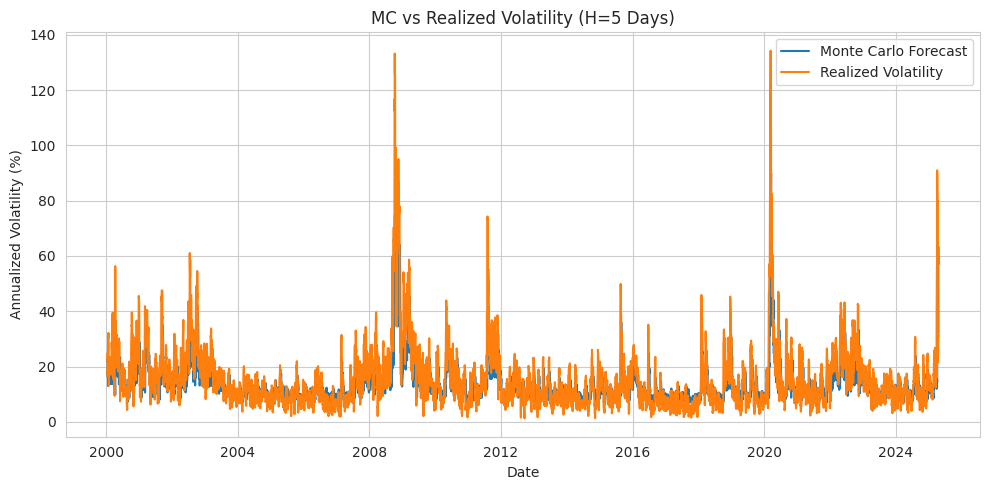

In [36]:
# Monte Carlo backtest settings
H = round(best_m/2 +0.5)        # days ahead
m = best_m     # ARCH order
omega = omega_best
alphas = alphas_best
N = 100        # number of Monte Carlo paths

# Prepare storage
mc_forecast = []
realized_vol = []
dates_bt = returns.index[m:len(returns)-H]

for idx in range(m, len(returns)-H):
    # 1) Build initial buffer of squared returns
    past_sq0 = list(returns.values[idx-m:idx]**2)

    # 2) Simulate N paths to forecast at t+H
    vol_h_sim = []
    for j in range(N):
        past_sq = past_sq0.copy()
        for h in range(1, H+1):
            var_h = omega + sum(alphas[i] * past_sq[-(i+1)] for i in range(m))
            # simulate shock and update eps
            eps_h = np.sqrt(var_h) * np.random.randn()
            past_sq.append(eps_h**2)
        # annualize and record vol at horizon H
        vol_h_sim.append(np.sqrt(past_sq[-1] * 252))

    # 3) Use the mean of the simulated vol distribution
    mc_forecast.append(np.mean(vol_h_sim))

    # 4) Compute realized vol over next H days
    fut = returns.values[idx:idx+H]
    realized_vol.append(np.sqrt((fut**2).sum() * 252 / H))

# Assemble DataFrame
df_mc = pd.DataFrame({
    'MC_forecast_vol': mc_forecast,
    'realized_vol': realized_vol
}, index=dates_bt)

# Compute error metrics
mae_mc  = (df_mc.MC_forecast_vol - df_mc.realized_vol).abs().mean()
rmse_mc = np.sqrt(((df_mc.MC_forecast_vol - df_mc.realized_vol)**2).mean())

print(f"MC Backtest H={H} days ⇒ MAE = {mae_mc:.3f}%, RMSE = {rmse_mc:.3f}%")

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df_mc.index, df_mc.MC_forecast_vol, label='Monte Carlo Forecast')
plt.plot(df_mc.index, df_mc.realized_vol, label='Realized Volatility')
plt.title(f"MC vs Realized Volatility (H={H} Days)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility (%)")
plt.legend()
plt.tight_layout()
plt.show()

So, while the RMSE increased with our Monte-Carlo simulations increased, our MAE decreased. Now none of that increase/decrease was statistically signficant, but it is an interesting modelling question. However, the simulations, somehow, seem more representative to the naked eye. Alas, we can see that our model works and it is ready to be put into actions.

## 5. Options Pricing

Finally, we can use our implemented volatility model to price some options. In this section we will looking at pricing options and identifying mispricings (relative to our model)


### Comparing Model vs Market Option Prices & Identifying Arbitrage

We will:

1. **Fetch** the current risk‑free rate $r_{\mathrm{rf}}$ from the 13‑week T‑bill yield (ticker `^IRX`).  
2. **Obtain** SPY’s spot price $S_0$ as the last adjusted close.  
3. **Download** the nearest‐expiration call option chain for SPY.  
4. **For each** call option:
   - Compute time to expiry \(T = \tfrac{\text{days to expiration}}{252}\).  
   - Select the ARCH($m^*$) forecasted volatility \(\hat\sigma_T\):  
     - If expiry $\le$ forecast horizon, use $\hat\sigma_{T}$ from our array;  
     - Otherwise use the last available forecast.  
   - Price the call via Black–Scholes:
     $
       C = S_0\,N(d_1) - K e^{-rT}N(d_2),
       \quad d_{1,2}=\frac{\ln(S_0/K)\pm\frac12\sigma^2 T}{\sigma\sqrt{T}}.
     $
   - Compute market mid‑price $\tfrac{\mathrm{bid}+\mathrm{ask}}2$.  
   - Calculate `pricing error = model − market`  
5. **Filter** strikes within ±20 % of ATM and **display** a comparison table and plot.  

A systematic deviation signals potential arbitrage opportunities once transaction costs are accounted for.

In [ ]:
# First lets define our Black–Scholes call pricing function (copied from class)
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [49]:
# Fetch r_rf and S0 as before
rfr = yf.download("^IRX", period="5d", interval="1d", progress=False)['Close'].iloc[-1]
r_rf = rfr / 100

S0 = prices.iloc[-1]

# Option chain & mid‑prices
spy = yf.Ticker("SPY")
expiry = spy.options[0]
calls = spy.option_chain(expiry).calls.copy()
calls['mid'] = (calls.bid + calls.ask) / 2

# Time to expiry
today = pd.to_datetime(returns.index[-1]).date()
exp_date = pd.to_datetime(expiry).date()
days_to_exp = (exp_date - today).days
T = days_to_exp / 252

# Volatility for this T, convert to decimal
if days_to_exp <= len(vol_ann):
    sigma_percent = vol_ann[days_to_exp-1]
else:
    sigma_percent = vol_ann[-1]
sigma = sigma_percent / 100  # **decimal**

# Model prices & errors
calls['model_price'] = calls['strike'].apply(lambda K: bs_call(S0, K, T, r_rf, sigma))
calls['error'] = calls['model_price'] - calls['mid']

# Filter ATM ±20%
atm_calls = calls.loc[abs(calls.strike - S0) <= 0.2 * S0]

# Display and plot
comparison = atm_calls[['strike','mid','model_price','error']].round(2)
print(f"Expiry: {expiry} (T={days_to_exp} days, σ={sigma_percent:.2f}% → {sigma:.4f} decimal)")
display(comparison.head(5))

Expiry: 2025-04-28 (T=3 days, σ=26.58% → 0.2658 decimal)


,strike,mid,model_price,error
3,480.0,70.84,70.88,0.04
4,485.0,65.84,65.88,0.04
5,490.0,60.86,60.88,0.03
6,495.0,55.86,55.89,0.03
7,500.0,50.96,50.89,-0.06


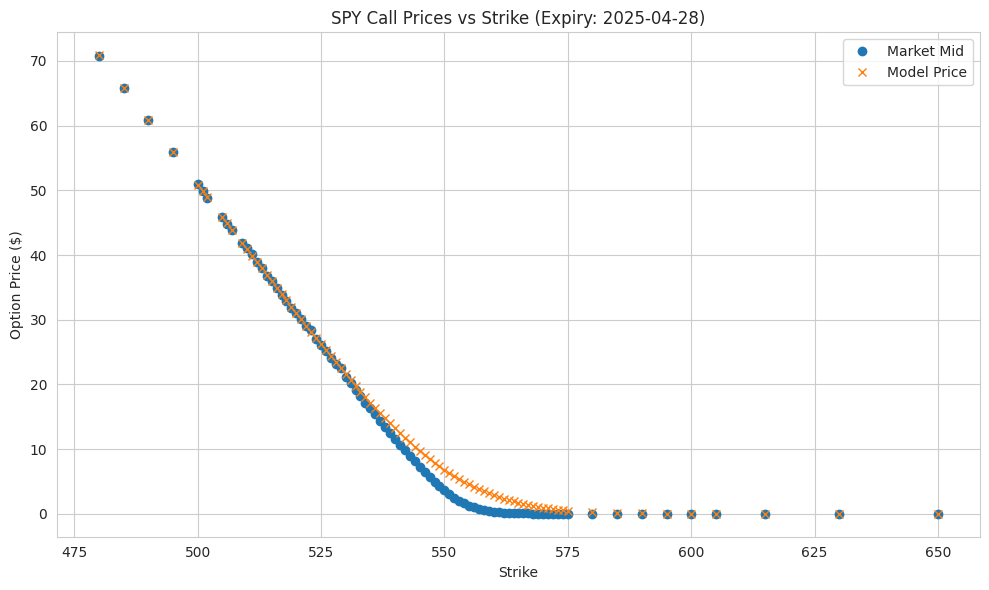

In [43]:
# Plotting our price vs market
plt.figure(figsize=(10,6))
plt.plot(atm_calls.strike, atm_calls.mid, 'o', label='Market Mid')
plt.plot(atm_calls.strike, atm_calls.model_price, 'x', label='Model Price')
plt.title(f"SPY Call Prices vs Strike (Expiry: {expiry})")
plt.xlabel("Strike")
plt.ylabel("Option Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot shows a very clear trend in underpricing Call options near the current stock price. This indicates that our volatility is higher than implied volatility. However, as much as we trust this model, we also understand its limitations and in an efficient market implied volatility is the expected volatility. Yet, we can still search for abritrage.

### Systematic Mispricing Scan Across Expirations

To identify potential arbitrage, we'll:

1. **Loop** over the next $N$ SPY option expirations (e.g., the nearest 5).  
2. **For each** expiration date:  
   - Compute **days to expiry** $d$.  
   - Select volatility $\sigma_d$ from our ARCH($m^*$) forecast (or use the final forecast if $d>H$).  
   - **Price** every call in the chain via Black–Scholes with $S_0,\,r_{\mathrm{rf}},\,\sigma_d,\,T=d/252$.  
   - Compute **mid‑market** $\tfrac{\mathrm{bid}+\mathrm{ask}}2$ and **pricing error**.  
3. **Aggregate** results into a single table.  
4. **Visualize** mispricing heatmap: strikes vs. days-to-expiry colored by error.  

This will highlight regions (strike/expiry combinations) where our ARCH‑based model diverges systematically from market prices, pointing to possible arbitrage after costs.

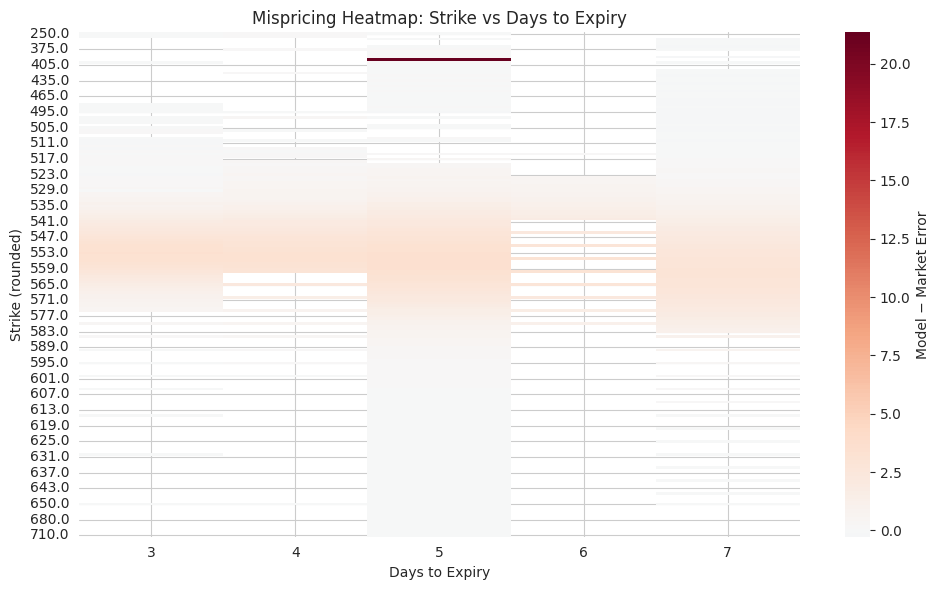

Top 5 Mispriced Options:


,days_to_expiry,strike,mid,model,error
7,5,395.0,134.62,155.97,21.35
72,5,556.0,2.96,6.43,3.47
73,5,557.0,2.56,6.03,3.47
71,5,555.0,3.38,6.84,3.46
74,5,558.0,2.22,5.66,3.44


In [50]:
spy = yf.Ticker("SPY")
expirations = spy.options[:5]   # next 5 expirations
results = []

# Loop over expirations and collect errors
today = pd.to_datetime(returns.index[-1]).date()
for exp in expirations:
    calls = spy.option_chain(exp).calls.copy()
    calls['mid'] = (calls.bid + calls.ask) / 2

    exp_date = pd.to_datetime(exp).date()
    days = (exp_date - today).days
    T = days / 252

    # select volatility, convert percent→decimal
    sigma_pct = vol_ann[days-1] if days <= len(vol_ann) else vol_ann[-1]
    sigma = sigma_pct / 100

    calls['model'] = calls['strike'].apply(lambda K: bs_call(S0, K, T, r_rf, sigma))
    calls['error'] = calls['model'] - calls['mid']
    calls['days_to_expiry'] = days

    results.append(calls[['strike','days_to_expiry','mid','model','error']])

# Combine and pivot for heatmap
df_all = pd.concat(results)
df_all['strike_round'] = df_all.strike.round(0)
pivot = df_all.pivot_table(
    index='strike_round',
    columns='days_to_expiry',
    values='error',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='RdBu_r', center=0, cbar_kws={'label':'Model − Market Error'})
plt.title('Mispricing Heatmap: Strike vs Days to Expiry')
plt.xlabel('Days to Expiry')
plt.ylabel('Strike (rounded)')
plt.tight_layout()
plt.show()

# Extract & display top 10 mispriced options
df_all['abs_error'] = df_all['error'].abs()
top_mis = df_all.sort_values('abs_error', ascending=False).head(5)

print("Top 5 Mispriced Options:")
display(top_mis[['days_to_expiry','strike','mid','model','error']].round(2))

In the end, we did find a glaring mispricing for a singular call option with 5 days to expiry. To get actionable prescriptive analysis we could expand on using put call parity to create abritage. But, perhaps that is a pursuit for another project.

## Conclusion

In this notebook we have built a complete ARCH‑based volatility and options‑pricing workflow:

1. **Data & Diagnostics**  
   - Fetched SPY prices and computed daily log‑returns.  
   - Examined distributional moments and ACF/PACF to confirm volatility clustering.

2. **Manual ARCH(m) Estimation**  
   - Implemented a generic `arch_m_nll` likelihood function.  
   - Fitted ARCH orders 1–10, automatically selected ARCH(9) by AIC/BIC.
   - Cross‑checked manual ARCH(9) against the `arch` library’s implementation and confirmed identical results.

3. **Volatility Forecasting**  
   - Produced both deterministic 30‑day ahead forecasts and Monte Carlo‐simulated volatility paths.  
   - Backtested forecasts against realized volatility, computing MAE/RMSE.

4. **Option Pricing & Mispricing Analysis**  
   - Pulled live Treasury yields for the risk‑free rate and SPY option chains.  
   - Priced calls via Black–Scholes using our ARCH forecasts.  
   - Generated heatmaps and tables of model vs. market mid‑prices to highlight potential arbitrage.

---

### Key Takeaways

- ARCH(9) captured long‑memory effects better than ARCH(1), but forecasting spikes remains challenging.  
- Monte Carlo simulation of volatility adds uncertainty bands and can improve backtest metrics slightly.  
- Mispricing heatmaps reveal systematic over‑ and under‑pricing regions that could inform a delta‑hedged arbitrage strategy.

---

### Next Steps

- Incorporate **GARCH** or **EGARCH** for more parsimonious persistence.  
- Extend the **delta‑hedged P&L backtest** to assess real arbitrage profitability net of transaction costs.  
- Automate rolling re‑estimation and live data ingestion for a production‑ready trading tool.
- Use more complex distributions like student's t-test and fractals to simulate

Thank you for following this project!